# Data processing

In [10]:
import os
from pathlib import Path
import glob
import numpy as np

directory_path = Path('data/Experiment1')

data = []

def generate_data(content):
    X_temp = []
    num_beacons = int(content[0].strip())
    lines_beacons_data = content[1:num_beacons+1]
    for line in lines_beacons_data:
        splitted_data = line.strip().split()
        beacon_cluster = int(splitted_data[0])
        beacon_ray_index = int(splitted_data[1])
        beacon_x_relative = np.double(splitted_data[2])
        beacon_y_relative = np.double(splitted_data[3])
        X_temp.append((beacon_x_relative, beacon_y_relative, beacon_ray_index))
    if num_beacons < 3:
        for _ in range(3 - num_beacons):
            X_temp.append((0, 0, 0))
    splitted_data = content[num_beacons + 1].strip().split()
    global_robot_x = np.double(splitted_data[0])
    global_robot_y = np.double(splitted_data[1])
    silhouette_result = np.double(content[num_beacons + 2])
    Y_temp = [global_robot_x, global_robot_y]
    return X_temp, Y_temp

for root, dirs, files in os.walk(directory_path):
    X_temp = []
    Y_temp = []
    for txt_file in glob.glob(os.path.join(root, '*.txt')):
        with open(txt_file, 'r') as file:
            content = file.readlines()
            X, Y = generate_data(content)
            X_temp.append(X)
            Y_temp.append(Y)
    if len(X_temp) > 0 and len(Y_temp) > 0:
        data.append((np.array(X_temp), np.array(Y_temp)))

data

[(array([[[ 4.27899384e+00, -8.90879798e-01,  3.38000000e+02],
          [ 2.68050244e+00,  3.41400477e-01,  3.80000000e+02],
          [ 4.21430013e+00,  1.68321182e+00,  4.05000000e+02]],
  
         [[ 4.05633613e+00, -4.62621379e-01,  3.49000000e+02],
          [ 4.06976843e+00,  2.09828350e+00,  4.16000000e+02],
          [-8.05858865e-01,  7.95440917e-01,  6.39000000e+02]],
  
         [[ 4.26795761e+00, -6.95825687e-01,  3.43000000e+02],
          [ 4.36872556e+00,  1.87893477e+00,  4.08000000e+02],
          [-5.52067935e-01,  7.16430962e-01,  6.26000000e+02]],
  
         [[ 4.00948192e+00,  8.71378824e-01,  3.86000000e+02],
          [ 3.39698559e+00,  3.34277449e+00,  4.50000000e+02],
          [-1.00842794e+00,  8.73025692e-01,  6.45000000e+02]],
  
         [[ 4.25654947e+00, -6.93865778e-01,  3.43000000e+02],
          [ 4.41464025e+00,  1.85290353e+00,  4.07000000e+02],
          [-5.35103776e-01,  7.97553961e-01,  6.17000000e+02]],
  
         [[-9.18109135e-01,  1.5618

2024-05-05 21:44:40.635372: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 21:44:40.636322: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 21:44:40.656319: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 21:44:40.656558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 21:44:41.021042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

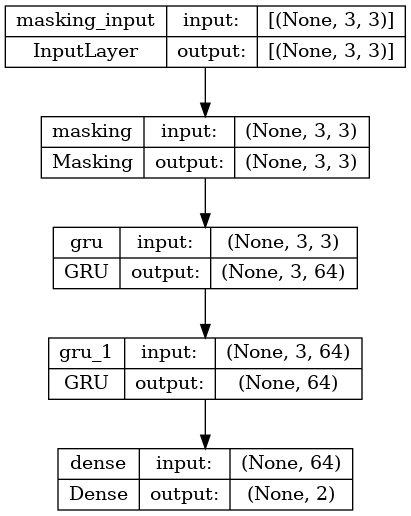

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking
from tensorflow.keras.utils import plot_model

model = Sequential([
    Masking(mask_value=0., input_shape=(3, 3)),
    GRU(64, return_sequences=True),
    GRU(64),
    Dense(2)  # Output layer: predicting 2 coordinates
])

model.compile(optimizer='adam', loss='mse')

# Generate a plot of the model architecture
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


# Learning and Print results

In [16]:
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


current_full_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
checkpoints_path = Path(f'checkpoints/{current_full_time}')
if not checkpoints_path.exists():
    checkpoints_path.mkdir(parents=True, exist_ok=True)

last_time = None

test_losses = []
predictions = []
true_values = []
for one_step_data in data:
    X = one_step_data[0]
    Y = one_step_data[1]
    # print(X, Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    model.fit(X_train, Y_train, epochs=30000, verbose=0)
    
    current_time = datetime.now().strftime("%H-%M-%S")
    last_time = current_time
    model_path = f'{checkpoints_path}/{current_time}.h5'
    model.save(model_path)
    
    loaded_model = load_model(model_path)
    Y_pred = loaded_model.predict(X_test)
    loss = loaded_model.evaluate(X_test, Y_test)
    test_losses.append(loss)
    predictions.append(Y_pred)
    true_values.append(Y_test)
    print("Test Loss:", loss)



/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 677ms/step - loss: 0.0153
Test Loss: 0.015262966975569725
1/1 [==============================] - 1s 1s/step - loss: 0.0818
Test Loss: 0.08183576911687851
1/1 [==============================] - 1s 664ms/step - loss: 0.0022
Test Loss: 0.002242473652586341
1/1 [==============================] - 1s 653ms/step - loss: 0.0178
Test Loss: 0.017801234498620033
1/1 [==============================] - 1s 1s/step - loss: 0.0352
Test Loss: 0.035214606672525406
1/1 [==============================] - 1s 673ms/step - loss: 0.0076
Test Loss: 0.007638528943061829
1/1 [==============================] - 1s 676ms/step - loss: 0.0351
Test Loss: 0.03508991375565529
1/1 [==============================] - 1s 1s/step - loss: 0.0323
Test Loss: 0.0323377288877964
1/1 [==============================] - 1s 681ms/step - loss: 0.0548
Test Loss: 0.05481940507888794
1/1 [==============================] - 1s 651ms/step - loss: 0.0211
Test Loss: 0.021103790029883385
1/1 [=========

In [27]:
import matplotlib.pyplot as plt
import imageio

def create_gif_for_sample(true, pred, sample_idx, checkpoints_path):
    filenames = []
    num_points = len(true)
    
    # Determine fixed axis limits
    all_x = np.concatenate([true[:, 0], pred[:, 0]])
    all_y = np.concatenate([true[:, 1], pred[:, 1]])
    min_x, max_x = all_x.min(), all_x.max()
    min_y, max_y = all_y.min(), all_y.max()

    # Add some padding to the limits
    x_pad = (max_x - min_x) * 0.1
    y_pad = (max_y - min_y) * 0.1
    limits = (min_x - x_pad, max_x + x_pad, min_y - y_pad, max_y + y_pad)

    for point in range(num_points + 1):
        plt.figure(figsize=(10, 6))
        plt.plot(true[:point, 0], true[:point, 1], color='blue', label='True Values' if point == 1 else "", marker='o')
        plt.plot(pred[:point, 0], pred[:point, 1], color='red', label='Predictions' if point == 1 else "", marker='o')
        
        # Highlight the last point in a different color
        if point > 0:
            plt.scatter(true[point-1, 0], true[point-1, 1], color='green', s=200, edgecolors='black')  # True values
            plt.scatter(pred[point-1, 0], pred[point-1, 1], color='yellow', s=200, edgecolors='black')  # Predictions

        # Set the limits to ensure consistent scaling
        plt.xlim(limits[0], limits[1])
        plt.ylim(limits[2], limits[3])

        plt.title(f'Test Sample {sample_idx + 1}, Point {point}')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        if point == 1:
            plt.legend()
        plt.grid(True)

        filename = f'{checkpoints_path}/sample_{sample_idx+1}_point_{point}.png'
        plt.savefig(filename)
        plt.close()  # Close the plot to free up memory
        filenames.append(filename)

    # Create GIF for the current sample
    images = [imageio.imread(filename) for filename in filenames]
    gif_path = f'{checkpoints_path}/sample_{sample_idx+1}.gif'
    imageio.mimsave(gif_path, images, fps=1)  # Adjust fps as needed for timing
    return gif_path

# Assuming 'true_values' and 'predictions' are lists of numpy arrays
checkpoints_path = Path(f'plots/{current_full_time}')
checkpoints_path.mkdir(parents=True, exist_ok=True)

# Create a GIF for each test sample
gif_paths = []
for idx, (true, pred) in enumerate(zip(true_values, predictions)):
    gif_path = create_gif_for_sample(true, pred, idx, checkpoints_path)
    gif_paths.append(gif_path)

print("Created GIFs at the following paths:")
for path in gif_paths:
    print(path)


/tmp/ipykernel_10409/1780154106.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filenames]


Created GIFs at the following paths:
plots/2024-05-05_20-13-19/sample_1.gif
plots/2024-05-05_20-13-19/sample_2.gif
plots/2024-05-05_20-13-19/sample_3.gif
plots/2024-05-05_20-13-19/sample_4.gif
plots/2024-05-05_20-13-19/sample_5.gif
plots/2024-05-05_20-13-19/sample_6.gif
plots/2024-05-05_20-13-19/sample_7.gif
plots/2024-05-05_20-13-19/sample_8.gif
plots/2024-05-05_20-13-19/sample_9.gif
plots/2024-05-05_20-13-19/sample_10.gif
plots/2024-05-05_20-13-19/sample_11.gif
plots/2024-05-05_20-13-19/sample_12.gif
plots/2024-05-05_20-13-19/sample_13.gif
plots/2024-05-05_20-13-19/sample_14.gif
plots/2024-05-05_20-13-19/sample_15.gif
plots/2024-05-05_20-13-19/sample_16.gif
plots/2024-05-05_20-13-19/sample_17.gif
plots/2024-05-05_20-13-19/sample_18.gif
plots/2024-05-05_20-13-19/sample_19.gif


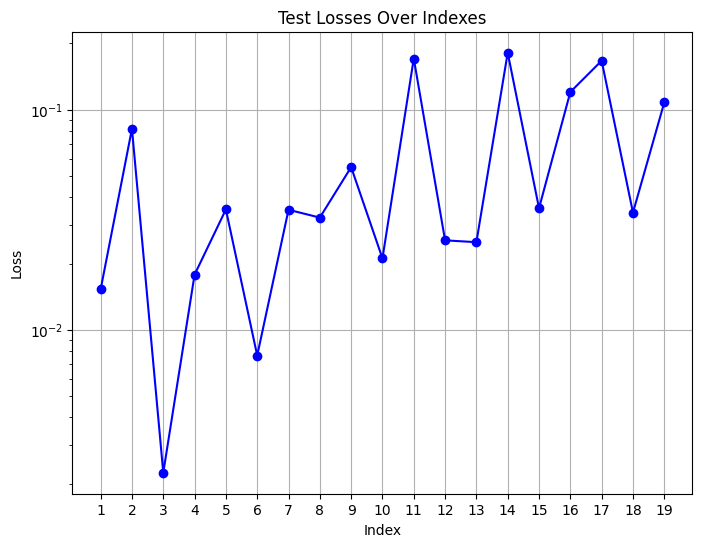

In [28]:

indexes = range(1, len(test_losses) + 1)

# Plotting the data
plt.figure(figsize=(8, 6))
plt.plot(indexes, test_losses, marker='o', linestyle='-', color='b')
plt.title('Test Losses Over Indexes')
plt.xlabel('Index')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(indexes)  # Set x-ticks to match the indexes
plt.yscale('log')  # Log scale due to the wide range of values
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model(f'{last_time}.h5')
